# Fig9. Relative weight of each department in the nine main research centres. To favour comparison, each group of values is stacked at 100%. 

#### Import libraries

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import matplotlib as mpl


plt.style.use('seaborn-muted')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

def read_csv(path):
    """
    :param path: of desir the xlsx file
    :return: String that contains all project descriptions
    """
    df = pd.read_csv(path)
    filtered_df = df.fillna(0)
    
    
    return filtered_df

#### Define projects data path

In [2]:
file_path = "data/mapeo_investigadores.csv"

#### Define function to clean data

In [3]:
def translate(dataframe, column_to_translate, translations_filename):    
    translations_df = pd.read_csv(f"data/{translations_filename}")
    translations_df.columns=["organismo", "acronimo"]
    translations_df['organismo'] = translations_df['organismo'].str.upper()
    translations_df['organismo'] = translations_df['organismo'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
    dataframe[column_to_translate] = dataframe[column_to_translate].str.upper()
    dataframe[column_to_translate] = dataframe[column_to_translate].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
    df_def = pd.merge(dataframe, translations_df, on=column_to_translate, how='inner')
    return df_def

In [4]:
def prepare_data(data, num_of_centres):
    data.drop_duplicates(subset ="ID investigador", keep = "first", inplace = True)
    data = data[data["Universidad"] != 0]
    data = data.loc[data["Universidad"] != 0]
    data = data.loc[data["Departamento / Centro"] != 0]
    mini = data[["ID investigador", "Universidad", "Departamento / Centro", "Área de procedencia/disciplina"]]
    mini.columns = ["id", "uni", "dpto", "disciplina"]
    mini.loc[mini["uni"]=="Agencia Estatal Consejo Superior de Investigaciones Científicas (CSIC)", "dpto"] = mini.loc[mini["uni"]=="Agencia Estatal Consejo Superior de Investigaciones Científicas (CSIC)", "disciplina"]
    mini = mini.drop(columns=['disciplina'])
    
    filtered_df = mini.loc[mini["dpto"].str.contains('\|')]
    mini = mini.loc[mini["dpto"].str.contains('\|') != True]
    new_discp = []
    for row in filtered_df.itertuples():
        for disciplina in row.dpto.split(" | "):
            new_discp.append([row.id, row.uni, disciplina])
    fix_df = pd.DataFrame(new_discp, columns=["id", "uni", "dpto"])
    mini = mini.append(fix_df)
    
    mini.loc[mini["dpto"].str.upper().str.contains('BIBLIOTECA'), "dpto"] = "Biblioteconomía y documentación"
    mini["dpto"] = mini.loc[:, "dpto"].str.upper()    
    translations_df = pd.read_csv(f"data/disciplinas.csv")
    translations_df.columns=["dpto", "translation"]
    translations_df['dpto'] = translations_df['dpto'].str.upper()
    translations_df['dpto'] = translations_df['dpto'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
    mini["dpto"] = mini["dpto"].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
    df_def = pd.merge(mini, translations_df, on="dpto", how='outer')
    
    display(df_def.loc[pd.isnull(df_def.translation)])
    
    uni_df = mini.groupby("uni").agg({'id': 'count'})
    uni_list = uni_df.nlargest(num_of_centres, "id").index.tolist()
    grp = df_def.groupby(['uni', 'translation']).agg({'id': 'count'})
    grp_pcts = grp.groupby(level=0).apply(lambda x: x / float(x.sum())).sort_values(['id'], ascending=False)
    # display(grp_pcts.loc[grp_pcts["organismo"].str.contains('UNIVERSIDAD COMPLUTENSE')])
    # df_def = translate(grp_pcts, "organismo", "universidades.csv")
    # result_df = grp_pcts.loc[grp_pcts["uni"].isin(uni_list)]
    result = grp_pcts[grp_pcts.index.isin(uni_list, level="uni")]
    result = result.reindex(uni_list, level="uni")
    unstacked = result.unstack()
    return unstacked# .sort_values(by='id', ascending=False)

#### Run program
## Change 'num_of_centres' to show as many centres as you want'

In [5]:
num_of_centres = 9
proyectos = read_csv(file_path)
df2 = prepare_data(proyectos, num_of_centres)

/home/aitor/github/desir/venv/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,id,uni,dpto,translation
227,2417.0,Universidad de Granada,DEPARTAMENTO DE URBANISTICA Y ORDENACION DEL T...,NaN
228,1542.0,Universidad de Granada,PREHISTORIA Y ARQUEOLOGIA,NaN
229,2547.0,Universidad de Alicante,PREHISTORIA Y ARQUEOLOGIA,NaN
230,2549.0,Universidad de Oviedo,PREHISTORIA Y ARQUEOLOGIA,NaN
231,2470.0,Universidad Pablo de Olavide,PREHISTORIA Y ARQUEOLOGIA,NaN
232,1710.0,Universidad Complutense de Madrid,PREHISTORIA Y ARQUEOLOGIA,NaN
233,2516.0,Universidad de Granada,PREHISTORIA Y ARQUEOLOGIA,NaN
234,1528.0,Universidad de Sevilla,PREHISTORIA Y ARQUEOLOGIA,NaN
235,2557.0,Universidad de Granada,PREHISTORIA Y ARQUEOLOGIA,NaN
236,1752.0,Universidad de Alicante,PREHISTORIA Y ARQUEOLOGIA,NaN


#### Print graph

<Figure size 432x288 with 0 Axes>

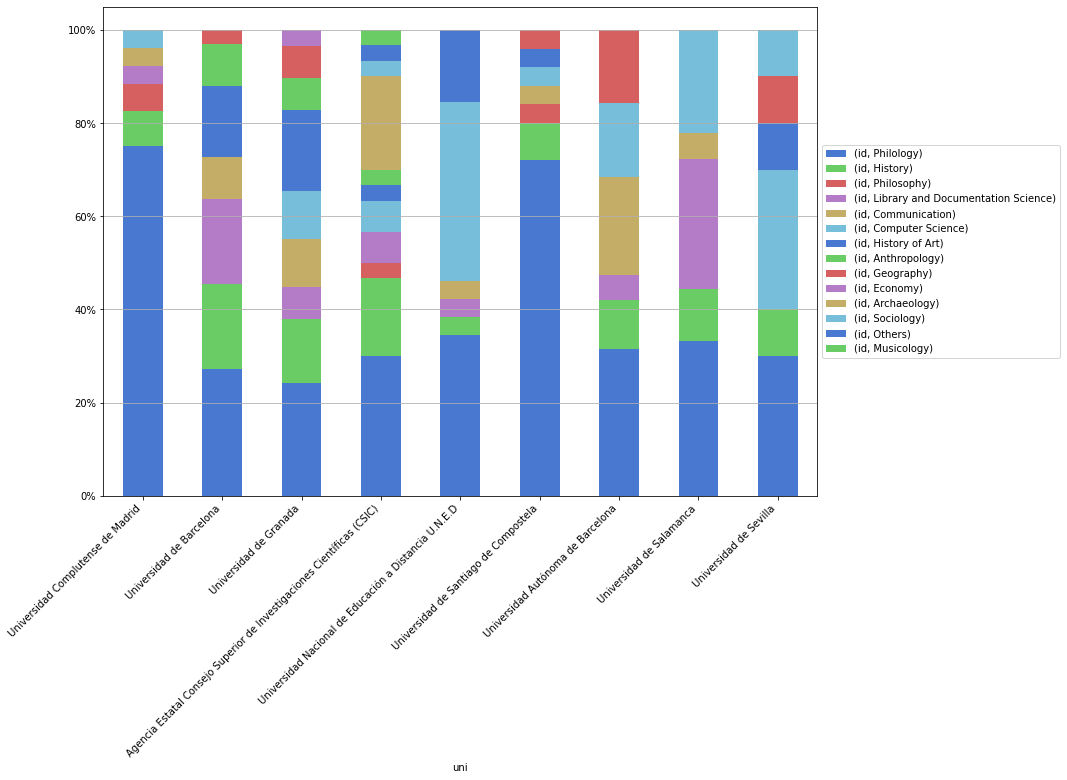

In [6]:
plt.figure()
ax1 = df2.plot(stacked=True, kind="bar", figsize=(16,9))
ax1.yaxis.set_major_formatter(ticker.PercentFormatter(1,decimals=0))
plt.grid(axis='y')
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Shrink current axis by 20%
box = ax1.get_position()
ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

In [7]:
df2

id            \
translation                                        Philology   History   
uni                                                                      
Universidad Complutense de Madrid                   0.750000  0.076923   
Universidad de Barcelona                            0.272727  0.181818   
Universidad de Granada                              0.241379  0.137931   
Agencia Estatal Consejo Superior de Investigaci...  0.300000  0.166667   
Universidad Nacional de Educación a Distancia U...  0.346154  0.038462   
Universidad de Santiago de Compostela               0.720000  0.080000   
Universidad Autónoma de Barcelona                   0.315789  0.105263   
Universidad de Salamanca                            0.333333  0.111111   
Universidad de Sevilla                              0.300000  0.100000   

                                                               \
translation                                        Philosophy   
uni                                                             
Universidad Complutense de Madrid                    0.057692   
Universidad de Barcelona                                  NaN   
Universidad de Granada                                    NaN   
Agencia Estatal Consejo Superior de Investigaci...   0.033333   
Universidad Nacional de Educación a Distancia U...        NaN   
Universidad de Santiago de Compostela                0.040000   
Universidad Autónoma de Barcelona                         NaN   
Universidad de Salamanca                                  NaN   
Universidad de Sevilla                                    NaN   

                                                                                      \
translation                                        Library and Documentation Science   
uni                                                                                    
Universidad Complutense de Madrid                                           0.038462   
Universidad de Barcelona                                                    0.181818   
Universidad de Granada                                                      0.068966   
Agencia Estatal Consejo Superior de Investigaci...                          0.066667   
Universidad Nacional de Educación a Distancia U...                          0.038462   
Universidad de Santiago de Compostela                                            NaN   
Universidad Autónoma de Barcelona                                           0.052632   
Universidad de Salamanca                                                    0.277778   
Universidad de Sevilla                                                           NaN   

                                                                  \
translation                                        Communication   
uni                                                                
Universidad Complutense de Madrid                       0.038462   
Universidad de Barcelona                                0.090909   
Universidad de Granada                                  0.103448   
Agencia Estatal Consejo Superior de Investigaci...           NaN   
Universidad Nacional de Educación a Distancia U...      0.038462   
Universidad de Santiago de Compostela                   0.040000   
Universidad Autónoma de Barcelona                       0.210526   
Universidad de Salamanca                                0.055556   
Universidad de Sevilla                                       NaN   

                                                                     \
translation                                        Computer Science   
uni                                                                   
Universidad Complutense de Madrid                          0.038462   
Universidad de Barcelona                                        NaN   
Universidad de Granada                                     0.103448   
Agencia Estatal Consejo Superior de Investigaci...         0.066667   
Universidad Nacio